In [1]:
import numpy as np
import cv2
import os
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
import pdb
from collections import Counter
import cyvlfeat as vlfeat

In [2]:
class_label =  os.listdir(f'hw5_data/train/')
print(class_label)

['Forest', 'Kitchen', 'Street', 'LivingRoom', 'Bedroom', 'TallBuilding', 'Mountain', 'Industrial', 'Office', 'Highway', 'Coast', 'Store', 'OpenCountry', 'InsideCity', 'Suburb', '.DS_Store']


# Bag of Word

## Read Images and Labels 

In [3]:
def readImages(path):
    label = []
    img = []
    for i in range(len(class_label)):
        dir_path = os.path.join(path,class_label[i])
        files = glob.glob(dir_path+'/*.jpg')
        for j in files:
            label.append(i)
            image = cv2.imread(j,cv2.IMREAD_GRAYSCALE)
            img.append(image)
    return label,img
train_labs, train_imgs = readImages('hw5_data/train')
test_labs, test_imgs = readImages('hw5_data/test/') 

## Find SIFT features

In [4]:
#feat_type = cv2.SIFT_create()
def detect_interest_p(img):
    #feat_type = cv2.SIFT_create()
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, desc = vlfeat.sift.dsift(img,step=10,fast=True)
    #p, desc = feat_type.detectAndCompute(img, None)
    return desc
train_features = [detect_interest_p(x) for x in train_imgs]
test_features = [detect_interest_p(x) for x in test_imgs]

## K-means on Features

- Deifinintion of K-means algorithm

In [5]:
class k_means:
    def __init__(self, k, data):
        self.iter = 0
        self.converge = False
        self.k = k
        self.N = data.shape[0]
        self.d = np.expand_dims(data,axis=1)
        self.data = data
        self.centers = None
        self.labels = None
        
    def initialize_centers(self,method='k-means++'):
        centers = []
        if method == 'k-means++':
            #initialize centers with "k-means++" method 
            
            #self.centers = np.empty(shape=(0,self.data.shape[1]))
            c1 = self.data[ np.random.choice(self.N)]
            centers.append(c1)
            for cnt in range(self.k - 1):
                print(f'initializing {cnt}th center')
                c = np.array(centers)
                p = np.empty(shape=(self.N,))
                for i in range(self.N):
                    p[i] = np.min(np.sum((self.data[i]-c) ** 2 , axis=1),axis=0)
                p = p/ np.sum(p)
                new_center = self.data[np.random.choice(self.N, p=p),:]
                centers.append(new_center)
        else: 
            # initialize randomly
            for i in range(self.k):
                print(f'initializing {i}th center')
                c = self.data[np.random.choice(self.N),:]
                centers.append(c)
        self.centers = np.stack(centers,axis=0)    
        self.find_labels()
        
    def find_labels(self):
        self.labels = np.empty(shape=(self.N,))
        #c = np.expand_dims(self.centers,axis=0)
        for i in range(self.N):
            self.labels[i] = np.argmin(np.sum((self.data[i,:]-self.centers) ** 2,axis=1),axis=0) 
        # The following line will use too much memory when N is large, be careful!!
        #self.labels = np.argmin(np.sum((self.d - c) ** 2, axis=2),axis=1)
        return 
    
    def find_centers(self):
        for i in range(self.k):
            self.centers[i] = np.mean(self.data[self.labels==i],axis=0)
            
    def one_step(self):
        l = self.labels.copy()
        self.find_centers()
        self.find_labels()
        if np.alltrue(l == self.labels):
            print('k-means converge!!')
            return True
        else :
            self.iter += 1
            return False
        
    def run_all(self,maxIter):
        for i in range(maxIter):
            print(f'starting iteration: {self.iter}')
            if self.one_step(): 
                break
                
    def classify(self,data):
        c = np.expand_dims(self.centers,axis=0)
        d = np.expand_dims(data,axis=1)
        labels = np.argmin(np.sum((d - c) ** 2, axis=2),axis=1)
        return labels

- test k-means


initializing 0th center
initializing 1th center
starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
k-means converge!!


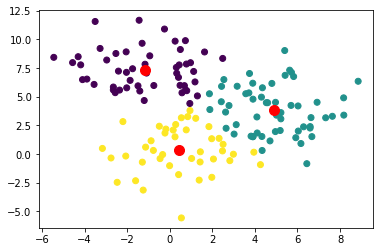

In [6]:
c = [[1,1,2],[5,4,2],[-1,7,2]]
d = np.empty(shape=(0,2))
for center in c:
    xs = np.random.normal(center[0],center[2],(50,))
    ys = np.random.normal(center[1],center[2],(50,))
    d = np.concatenate([d,np.stack([xs,ys],axis=1)],axis=0)
    
km = k_means(3,d)
km.initialize_centers(method='k-means++')
km.run_all(20)
plt.scatter(d[:,0],d[:,1],c=km.labels)
plt.scatter(km.centers[:,0],km.centers[:,1],c='r',s=100)
plt.show()

- run k-means on all descriptors from training set

In [7]:
fs = np.concatenate(train_features,axis=0)
fs = fs.astype('float32')
print(fs.shape)

(965994, 128)


In [ ]:
k= 150
km = k_means(k,fs)
# My implementation runs very slow, use scipy.cluster is faster 

#km.initialize_centers(method='random')
#km.run_all(1000)

from scipy.cluster.vq import *
codebook, distortion = kmeans2(fs,k, minit='++')
km.centers = codebook

- Save K-means center as intermediate result

In [ ]:
with open(f'k_means_k={k}.npy', 'wb') as f:
    np.save(f,km.centers)


- Load K-means centers from file

In [28]:
with open(f'k_means_k={k}.npy', 'rb') as f:
    km.centers = np.load(f)

- Convert training and testing images to new feature space

In [ ]:
# this may take very long
train_bags = []
for f in train_features:
    words = km.classify(f)
    hist= [Counter(words)[i] for i in range(k)]
    train_bags.append(hist)
    
    
test_bags = []
for f in test_features:
    words = km.classify(f)
    hist= [Counter(words)[i] for i in range(k)]
    test_bags.append(hist)

train_bags = np.array(train_bags,dtype='float')
test_bags = np.array(test_bags,dtype='float')


# The following alternative version will be extremely slow due to memory constraint

#train_bag = np.array([
#               [Counter(km.classify(x))[i]for i in range(k)]
#               for x in train_features
#            ],dtype='float')
#
#test_bag = np.array([
#               [Counter(km.classify(x))[i] for i in range(k)]
#               for x in test_features
#           ],dtype='float')

### Normalizing Bag-of-SIFT features
this processs is only needed when using inner product as similarity in KNN

### Plot Histogram

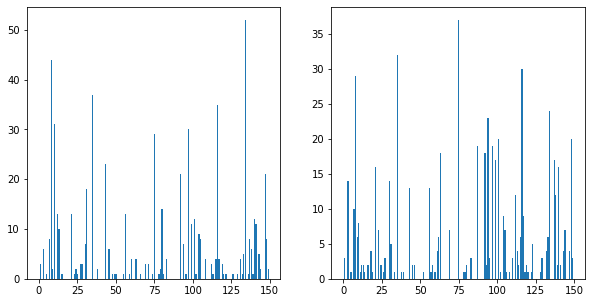

In [49]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,2)
ax[0].bar(np.arange(k),height=train_bags[0,:])
ax[1].bar(np.arange(k),height=test_bags[0,:])
plt.show()

### K-Nearest Neighbour

In [ ]:
from scipy.spatial import distance
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def distance(self, X1, X2):
        distance = scipy.spatial.distance.euclidean(X1, X2)

    def predict(self, X_test):
        final_output = []
        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(self.X_train)):
                dist = distance.euclidean(self.X_train[j],X_test[i])
                #dist = -self.X_train[j] @ X_test[i]
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            for d, j in d:
                votes.append(self.y_train[j])
            ans = Counter(votes).most_common(1)[0][0]
            final_output.append(ans)

        return final_output

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        cnt = 0
        for i in range(len(y_test)):
            if predictions[i] == y_test[i]:
                cnt += 1
        return cnt/ len(y_test)

In [ ]:
acc_list = []
for i in range(60):
    clf = KNN(i+1)
    clf.fit(train_bags, train_labs)
    acc = clf.score(test_bags,test_labs)
    print(f'k = {i+1}, acc = {acc}')
    acc_list.append(acc)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 61, step=1),acc_list, marker='o')
plt.xticks(np.arange(1, 61, step=2))
plt.title('Bag_of_SIFT + KNN')
plt.xlabel("number of voters(K)")
plt.ylabel("accuracy")
print(f'best Acc = {max(acc_list)}')
print(f'best k =  {np.argmax(acc_list)}')

## SVM

In [34]:
import libsvm.svmutil as svm

In [35]:
# Linear kernel 
m_Linear = svm.svm_train(train_labs,train_bags,'-s 0 -t 0')
_,acc_Linear ,_  = svm.svm_predict(test_labs,test_bags,m_Linear)

#polynomial kernel, with coef0 = 1, degree = 3
m_Poly = svm.svm_train(train_labs,train_bags,'-s 0 -t 1 -r 1')
_,acc_Poly ,_  = svm.svm_predict(test_labs,test_bags,m_Poly)

# RBF kernel with C = 1 , gamma = 1/k
m_RBF = svm.svm_train(train_labs,train_bags,'-s 0 -t 2')
_,acc_RBF ,_  = svm.svm_predict(test_labs,test_bags,m_RBF)

#Sigmoid kernel coef0 = 0
m_Sigmoid = svm.svm_train(train_labs,train_bags,'-s 0 -t 3')
_,acc_Sigmoid ,_  = svm.svm_predict(test_labs,test_bags,m_Sigmoid)

Accuracy = 66% (99/150) (classification)
Accuracy = 68% (102/150) (classification)
Accuracy = 18% (27/150) (classification)
Accuracy = 6% (9/150) (classification)


In [36]:
step = 2
C0_ln = -5
gamma0_ln = -25
acc = np.zeros(shape=(20,20))
for i in range(20):
    for j in range(20):
        C = 2** (C0_ln + i)
        gamma = 2 ** (gamma0_ln + j)
        acc[i][j] = svm.svm_train(train_labs, train_bags,f'-s 0 -t 2 -g {gamma} -c {C} -v 2' )

Cross Validation Accuracy = 42.0667%
Cross Validation Accuracy = 46.4667%
Cross Validation Accuracy = 48.8%
Cross Validation Accuracy = 50.8%
Cross Validation Accuracy = 45.2%
Cross Validation Accuracy = 31.8%
Cross Validation Accuracy = 23.9333%
Cross Validation Accuracy = 13.6%
Cross Validation Accuracy = 11.9333%
Cross Validation Accuracy = 17.6667%
Cross Validation Accuracy = 46.1333%
Cross Validation Accuracy = 46.3333%
Cross Validation Accuracy = 45.6667%
Cross Validation Accuracy = 35.6667%
Cross Validation Accuracy = 8.73333%
Cross Validation Accuracy = 6.8%
Cross Validation Accuracy = 6.93333%
Cross Validation Accuracy = 6.8%
Cross Validation Accuracy = 6.93333%
Cross Validation Accuracy = 6.66667%
Cross Validation Accuracy = 43.0667%
Cross Validation Accuracy = 46.2%
Cross Validation Accuracy = 49.4%
Cross Validation Accuracy = 50.0667%
Cross Validation Accuracy = 46%
Cross Validation Accuracy = 31.2%
Cross Validation Accuracy = 22.6667%
Cross Validation Accuracy = 12%
Cross 

(max_ln_C, max_ln_gamma) = (2,-13)
max_acc = 63.733333333333334


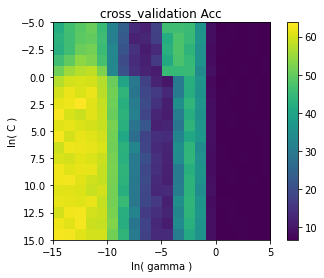

In [37]:
plt.imshow(acc,extent=[-25,-5,15,-5])
plt.colorbar()
plt.xlabel('ln( gamma )')
plt.ylabel('ln( C )')
plt.title('cross_validation Acc')
max_i, max_j = np.argmax(acc) // 20, np.argmax(acc)%20
max_lnc, max_ln_gamma = (max_i-5, max_j-25)
print(f'(max_ln_C, max_ln_gamma) = ({max_lnc},{max_ln_gamma})')
print(f'max_acc = {np.max(acc)}')

In [38]:
m_RBF = svm.svm_train(train_labs,train_bags,f'-s 0 -t 2 -g {2.0 ** max_ln_gamma} -c {2.0 ** max_lnc}')
_,acc_RBF ,_  = svm.svm_predict(test_labs,test_bags,m_RBF)

Accuracy = 68% (102/150) (classification)


## Optimize Parameters for Linear SVM

In [39]:
# Linear kernel 
#m_Linear = svm.svm_train(train_labs,train_bags,'-s 0 -t 0')
#_,acc_Linear ,_  = svm.svm_predict(test_labs,test_bags,m_Linear)

#polynomial kernel, with coef0 = 1, degree = 3
#m_Poly = svm.svm_train(train_labs,train_bags,'-s 0 -t 1 -r 1')
#_,acc_Poly ,_  = svm.svm_predict(test_labs,test_bags,m_Poly)

Linear_Acc = []
for i in range(20):
    C = 2**(i-10)
    acc = svm.svm_train(train_labs, train_bags,f'-s 0 -t 0 -c {C} -v 5' )
    Linear_Acc.append(acc)

Cross Validation Accuracy = 64.0667%
Cross Validation Accuracy = 63.5333%
Cross Validation Accuracy = 62.7333%
Cross Validation Accuracy = 61.7333%
Cross Validation Accuracy = 61.3333%
Cross Validation Accuracy = 61.6667%
Cross Validation Accuracy = 61.9333%
Cross Validation Accuracy = 62.2%
Cross Validation Accuracy = 60.9333%
Cross Validation Accuracy = 61%
Cross Validation Accuracy = 62.8667%
Cross Validation Accuracy = 61.4667%
Cross Validation Accuracy = 61.2667%
Cross Validation Accuracy = 61.1333%
Cross Validation Accuracy = 61.6%
Cross Validation Accuracy = 60.5333%
Cross Validation Accuracy = 63.1333%
Cross Validation Accuracy = 61.4%
Cross Validation Accuracy = 60.5333%
Cross Validation Accuracy = 62.3333%


best Acc = 64.06666666666668
best C =  0.0009765625


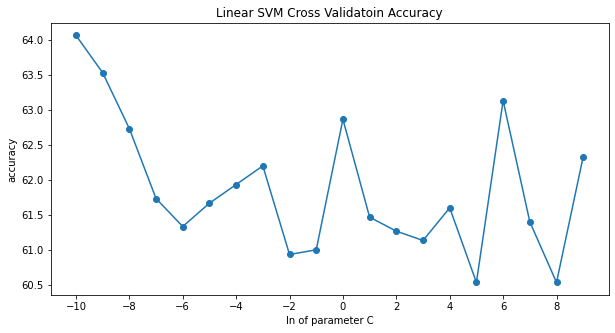

In [40]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(-10, 10, step=1),Linear_Acc, marker='o')
plt.xticks(np.arange(-10, 10, step=2))
plt.title('Linear SVM Cross Validatoin Accuracy')
plt.xlabel("ln of parameter C")
plt.ylabel("accuracy")
print(f'best Acc = {max(Linear_Acc)}')
print(f'best C =  {2 **(np.argmax(Linear_Acc)-10.0)}')

In [45]:
lin_max_model = svm.svm_train(train_labs, train_bags,f'-s 0 -t 0 -c {2 **(np.argmax(Linear_Acc)-10.0)}' )
_,acc_Linear ,_  = svm.svm_predict(test_labs,test_bags,lin_max_model)

Accuracy = 67.3333% (101/150) (classification)
